In [154]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
import math
import random
import numpy as np
import cv2
sys.path.append('../')
from mrcnn.visualize import display_images
from mrcnn.dataset  import Dataset
from mrcnn.shapes   import ShapesConfig
from mrcnn.datagen  import load_image_gt
from mrcnn.visualize import draw_boxes
import  mrcnn.utils     as utils
img_h, img_w = 128, 128

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [155]:
class NewShapesConfig(ShapesConfig):
    '''
    Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    '''
    # Give the configuration a recognizable name
#     NAME = "shapes"

    # Number of classes (including background)
    NUM_CLASSES = 1 + 4  # background + 3 shapes


class NewShapesDataset(Dataset):
    '''
    Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    '''

    def load_shapes(self, count, height, width):
        '''
        Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        '''
        
        # Add classes
        self.add_class("shapes", 1, "circle")  # used to be class 2
        self.add_class("shapes", 2, "square")  # used to be class 1
        self.add_class("shapes", 3, "triangle")
        self.add_class("shapes", 4, "rectangle")
    
        # Add images
        # Generate random specifications of images (i.e. color and
        # list of shapes sizes and locations). This is more compact than
        # actual images. Images are generated on the fly in load_image().
        for i in range(count):
            bg_color, shapes = self.random_image(height, width)
            self.add_image("shapes", image_id=i, path=None,
                           width=width, height=height,
                           bg_color=bg_color, shapes=shapes)

    def load_image(self, image_id):
        '''
        Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but in this case it
        generates the image on the fly from the specs in image_info.
        '''
        
        info = self.image_info[image_id]
        bg_color = np.array(info['bg_color']).reshape([1, 1, 3])
        
        image = np.ones([info['height'], info['width'], 3], dtype=np.uint8)
        image = image * bg_color.astype(np.uint8)
        
        for shape, color, dims in info['shapes']:
            image = self.draw_shape(image, shape, dims, color)
        return image

    
    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["shapes"]
        else:
            super(self.__class__).image_reference(self, image_id)    

            
    def draw_shape(self, image, shape, dims, color):
        """Draws a shape from the given specs."""
        # Get the center x, y and the size s
        x, y, sx, sy = dims
        print(' Shape : {}     Cntr (x,y) : ({} , {})    Size_x : {} Size_y: {}'.format(shape,x,y,sx, sy))    
        if shape == 'square':
            image = cv2.rectangle(image, (x - sx, y - sy), (x + sx, y + sy), color, -1)
        elif shape == 'rectangle':
            image = cv2.rectangle(image, (x - sx, y - sy), (x + sx, y + sy), color, -1)        

        elif shape == "circle":
            image = cv2.circle(image, (x, y), sx, color, -1)

        elif shape == "triangle":
            sin60 = math.sin(math.radians(60))
            points = np.array([[(x, y - sx),
                                (x - (sx / sin60), y + sx),
                                (x + (sx / sin60), y + sx),
                                ]], dtype=np.int32)
            print(' points.shape is : ',points.shape)
            print(points)
            image = cv2.fillPoly(image, points, color)
        return image            

    def random_shape(self,height, width):
        """Generates specifications of a random shape that lies within
        the given height and width boundaries.
        Returns a tuple of three valus:
        * The shape name (square, circle, ...)
        * Shape color: a tuple of 3 values, RGB.
        * Shape dimensions: A tuple of values that define the shape size
                            and location. Differs per shape type.
        """
        # Shape
        shape = random.choice(["square", "circle", "triangle", "rectangle"])
        # Color
        color = tuple([random.randint(0, 255) for _ in range(3)])
        # Center x, y
        buffer = 20
        y = random.randint(buffer, height - buffer - 1)
        x = random.randint(buffer, width - buffer - 1)
        # Size
        sx = random.randint(buffer, width // 4)
        if shape == "rectangle":
            sy = random.randint(buffer, height // 4)    
        else:
            sy = sx
        return shape, color, (x, y, sx, sy)
    
    def random_image(self, height, width):
        '''
        Creates random specifications of an image with multiple shapes.
        Returns the background color of the image and a list of shape
        specifications that can be used to draw the image.
        '''
        # Pick random background color
        bg_color = np.array([random.randint(0, 255) for _ in range(3)])
        # Generate a few random shapes and record their
        # bounding boxes
        shapes = []
        boxes = []
        N = random.randint(1, 4)

        for _ in range(N):
            shape, color, dims = self.random_shape(height, width)
            shapes.append((shape, color, dims))
            x, y, sx, sy = dims
            boxes.append([y - sy, x - sx, y + sy, x + sx])
        
        # Suppress occulsions more than 0.3 IoU    
        # Apply non-max suppression with 0.3 threshold to avoid shapes covering each other
        keep_ixs = utils.non_max_suppression(np.array(boxes), np.arange(N), 0.3)
        
        shapes = [s for i, s in enumerate(shapes) if i in keep_ixs]
        
        # print('Original number of shapes {}  # after NMS {}'.format(N, len(shapes)))
        return bg_color, shapes    
    
    
    
'''
-------------------------------------------------------------------------------
'''
def semi_random_image(self, height, width):
    '''
    Creates random specifications of an image with multiple shapes.
    Returns the background color of the image and a list of shape
    specifications that can be used to draw the image.
    '''
    # Pick random background color
    bg_color = np.array([random.randint(0, 255) for _ in range(3)])
    # Generate a few random shapes and record their
    # bounding boxes
    shapes = []
    boxes = []
    N = random.randint(1, 4)

    for _ in range(N):
        shape, color, dims = self.random_shape(height, width)
        shapes.append((shape, color, dims))
        x, y, sx, sy = dims
        boxes.append([y - sy, x - sx, y + sy, x + sx])

    # Suppress occulsions more than 0.3 IoU    
    # Apply non-max suppression with 0.3 threshold to avoid shapes covering each other
    keep_ixs = utils.non_max_suppression(np.array(boxes), np.arange(N), 0.3)

    shapes = [s for i, s in enumerate(shapes) if i in keep_ixs]

    # print('Original number of shapes {}  # after NMS {}'.format(N, len(shapes)))
    return bg_color, shapes

def semi_random_shape(height, width, shape = None, x = 0, y = 0, sx = 0, sy = 0):
    """Generates specifications of a random shape that lies within
    the given height and width boundaries.
    Returns a tuple of three valus:
    * The shape name (square, circle, ...)
    * Shape color: a tuple of 3 values, RGB.
    * Shape dimensions: A tuple of values that define the shape size
                        and location. Differs per shape type.
    """
    # Shape
    if shape is None:
        shape = random.choice(["square", "circle", "triangle", "rectangle"])
    # Color
    color = tuple([random.randint(0, 255) for _ in range(3)])
    # Center x, y
    buffer = 20
    if y == 0:
        y = random.randint(buffer, height - buffer - 1)
    if x == 0: 
        x = random.randint(buffer, width - buffer - 1)
    # Size
    if sx == 0 :
        sx = random.randint(buffer, width // 4)
    if shape == "rectangle" and sy == 0 :
        sy = random.randint(buffer, height // 4)
    else:
        sy = sx
#     print(' Shape : {}     Cntr (x,y) : ({} , {})    Size_x: {} Size_y: {}'.format(shape,x,y,sx, sy))    
    return shape, color, (x, y, sx, sy)

def semi_draw_shape(image, shape, dims, color):
    """Draws a shape from the given specs."""
    # Get the center x, y and the size s
    x, y, sx, sy = dims
    print(' Shape : {}     Cntr (x,y) : ({} , {})    Size_x: {} Size_y: {}'.format(shape,x,y,sx, sy))    
    if shape == 'square':
        image = cv2.rectangle(image, (x - sx, y - sy), (x + sx, y + sy), color, -1)
    elif shape == 'rectangle':
        image = cv2.rectangle(image, (x - sx, y - sy), (x + sx, y + sy), color, -1)        

    elif shape == "circle":
        image = cv2.circle(image, (x, y), sx, color, -1)

    elif shape == "triangle":
        sin60 = math.sin(math.radians(60))
        points = np.array([[(x, y - sx),
                            (x - (sx / sin60), y + sx),
                            (x + (sx / sin60), y + sx),
                            ]], dtype=np.int32)
#         print(' points.shape is : ',points.shape)
#         print(points)
        image = cv2.fillPoly(image, points, color)
    return image            

 Shape : square     Cntr (x,y) : (54 , 39)    Size_x: 23 Size_y: 23
 Shape : triangle     Cntr (x,y) : (86 , 88)    Size_x: 31 Size_y: 31
 Shape : rectangle     Cntr (x,y) : (67 , 104)    Size_x: 25 Size_y: 26
 Shape : triangle     Cntr (x,y) : (101 , 95)    Size_x: 28 Size_y: 28
 Shape : triangle     Cntr (x,y) : (82 , 59)    Size_x: 21 Size_y: 21


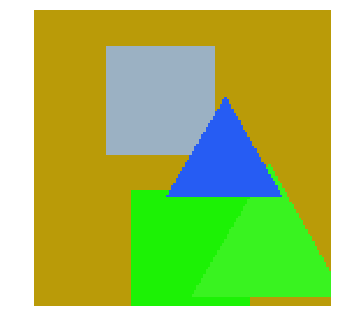

In [156]:
bg_color = np.array([random.randint(0, 255) for _ in range(3)])
color = tuple([random.randint(0, 255) for _ in range(3)])

image = np.ones([img_h, img_w, 3], dtype=np.uint8)
image = image * bg_color.astype(np.uint8)
for i in range(5):
    shape , color, dims = semi_random_shape(img_h, img_w )
    image = semi_draw_shape(image , shape, dims ,color)

display_images([image], cols = 1, width = 6)

In [143]:
test  = NewShapesDataset()
test.load_shapes(10, 128, 128)


 non_max_suppression 
====> Initial Ixs:  [3 2 1 0]
 starting ixs :  [3 2 1 0]  compare  3  with  [2 1 0]
 np.where( iou > threshold) :  (array([2], dtype=int64),) tst[0] (index into ixs[1:]:  [2]  remove_ixs (index into ixs) :  [3]
 edning ixs (after deleting ixs[0]):  [2 1]  picked so far:  [3]
 starting ixs :  [2 1]  compare  2  with  [1]
 np.where( iou > threshold) :  (array([], dtype=int64),) tst[0] (index into ixs[1:]:  []  remove_ixs (index into ixs) :  []
 edning ixs (after deleting ixs[0]):  [1]  picked so far:  [3, 2]
 starting ixs :  [1]  compare  1  with  []
 np.where( iou > threshold) :  (array([], dtype=int64),) tst[0] (index into ixs[1:]:  []  remove_ixs (index into ixs) :  []
 edning ixs (after deleting ixs[0]):  []  picked so far:  [3, 2, 1]
====> Final Picks:  [3, 2, 1]
 non_max_suppression 
====> Initial Ixs:  [2 1 0]
 starting ixs :  [2 1 0]  compare  2  with  [1 0]
 np.where( iou > threshold) :  (array([0], dtype=int64),) tst[0] (index into ixs[1:]:  [0]  remove_ix

In [148]:

test.prepare()
test_config = NewShapesConfig()

 Initialize config object - super


In [149]:
test.image_ids

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [150]:
image_index = 0
image_id = test.image_ids[image_index]
image, image_meta, gt_class_ids, gt_boxes, gt_masks = \
                load_image_gt(test, test_config, image_id, augment=False, use_mini_mask=False)

 Shape : triangle     Cntr (x,y) : (24 , 38)    Size_x : 27 Size_y: 27
 points.shape is :  (1, 3, 2)
[[[24 11]
  [-7 65]
  [55 65]]]
 Shape : rectangle     Cntr (x,y) : (102 , 102)    Size_x : 31 Size_y: 23
 Shape : square     Cntr (x,y) : (88 , 79)    Size_x : 25 Size_y: 25


(0,) (0, 4) (0, 0, 0)
[]
[]


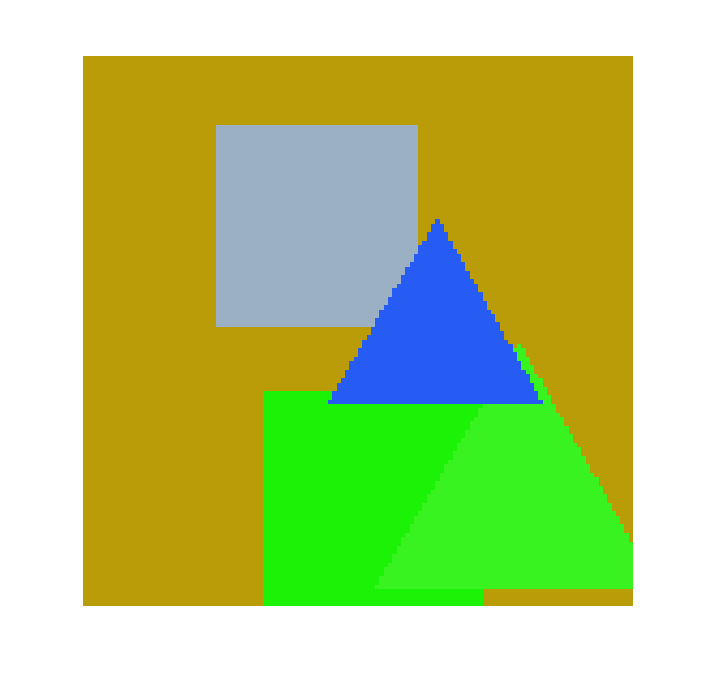

In [157]:
print(gt_class_ids.shape, gt_boxes.shape, gt_masks.shape)
print(gt_boxes)
print(gt_class_ids)
draw_boxes(image, gt_boxes)